## Imports and Variables

In [1]:
import pandas
import numpy
import librosa
import requests
import seaborn
import sklearn
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [2]:
labels = ['dishwasher', 'washing_machine', 'shower', 'washing_hands', 'flushing_toilet']

## Data Collection & Feature Extraction

In [3]:
# Get list of all recordings
data = requests.get("https://dolphin-app-9sdeq.ondigitalocean.app/api/v1/recordings").json()

recordings = []

for recording in data:
    recordings.append({
        "path": f'../recordings/combined/{recording["name"]}',
        "label": recording["label"],
        "environment": recording["environment"],
        "mfcc_mean": None,
        "mfcc_var": None,
        "n_samples": None,
        "chroma_mean": None,
        "chroma_var": None,
        "rms_mean": None,
        "rms_var": None,
        "sc_mean": None,
        "sc_var": None
    })

dataframe = pandas.json_normalize(recordings)

dataframe.head()

,path,label,environment,mfcc_mean,mfcc_var,n_samples,chroma_mean,chroma_var,rms_mean,rms_var,sc_mean,sc_var
0,../recordings/combined/a196dbae-1f50-4d0e-b345...,washing_hands,marsberg,None,None,None,None,None,None,None,None,None
1,../recordings/combined/826e36b1-2a7e-4d22-9c81...,washing_hands,marsberg,None,None,None,None,None,None,None,None,None
2,../recordings/combined/9a6b6b01-e466-47fb-9fcc...,washing_hands,marsberg,None,None,None,None,None,None,None,None,None
3,../recordings/combined/84ee02e6-44d5-4ab3-b875...,washing_hands,marsberg,None,None,None,None,None,None,None,None,None
4,../recordings/combined/ec24c55a-39ec-4b36-86fe...,washing_hands,marsberg,None,None,None,None,None,None,None,None,None


In [4]:
# Function to extract features
def preprocess(dataframe):
    for index, row in tqdm(dataframe.iterrows()):
        audio, sample_rate = librosa.load(row["path"])
        
        # Calculate mean and variance of the MFCCs
        mfcc_stft = librosa.feature.mfcc(y=audio, sr=sample_rate)
        dataframe.at[index, "mfcc_mean"] = numpy.mean(mfcc_stft)
        dataframe.at[index, "mfcc_var"] = numpy.var(mfcc_stft)
        
        # Calculate number of samples, representing length
        dataframe.at[index, "n_samples"] = audio.shape[0]

        # Calculate mean and variance of the chromagram
        chroma_stft = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
        dataframe.at[index, "chroma_mean"] = numpy.mean(chroma_stft)
        dataframe.at[index, "chroma_var"] = numpy.var(chroma_stft)
        
        # Calculate mean and variance of the root mean square array
        rms = librosa.feature.rms(y=audio)
        dataframe.at[index, "rms_mean"] = numpy.mean(rms)
        dataframe.at[index, "rms_var"] = numpy.var(rms)
        
        # Calculate mean and variance of the spectral centroid
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sample_rate)
        dataframe.at[index, "sc_mean"] = numpy.mean(spectral_centroid)
        dataframe.at[index, "sc_var"] = numpy.var(spectral_centroid)
        
    return dataframe

dataframe = preprocess(dataframe)

119it [03:59,  2.01s/it]


In [5]:
# Extract separate dataframes for environments marsberg and duesseldorf
dataframe_marsberg = dataframe[dataframe["environment"] == "marsberg"]
dataframe_duesseldorf = dataframe[dataframe["environment"] == "duesseldorf"]

In [16]:
dataframe_marsberg

,path,label,environment,mfcc_mean,mfcc_var,n_samples,chroma_mean,chroma_var,rms_mean,rms_var,sc_mean,sc_var
0,../recordings/combined/a196dbae-1f50-4d0e-b345...,3,marsberg,-27.676704,19290.720703,2259243,0.510744,0.064451,0.000268,0.0,4039.849911,22786.888439
1,../recordings/combined/826e36b1-2a7e-4d22-9c81...,3,marsberg,-27.430916,19336.501953,1017387,0.505415,0.067332,0.000268,0.0,4047.545843,31016.973748
2,../recordings/combined/9a6b6b01-e466-47fb-9fcc...,3,marsberg,-27.275898,19287.546875,1035799,0.508465,0.068212,0.000272,0.0,4017.004389,29156.230358
3,../recordings/combined/84ee02e6-44d5-4ab3-b875...,3,marsberg,-27.048124,19276.820312,1581845,0.502856,0.068207,0.000278,0.0,3996.417722,28836.591416
4,../recordings/combined/ec24c55a-39ec-4b36-86fe...,3,marsberg,-27.311382,19310.251953,892959,0.508524,0.067869,0.000273,0.0,4022.255436,35037.803311
...,...,...,...,...,...,...,...,...,...,...,...,...
66,../recordings/combined/538da1c3-1f14-452e-8378...,1,marsberg,-24.173405,17489.919922,890908,0.466656,0.089942,0.000715,0.0,3099.993795,538289.786033
67,../recordings/combined/fe317879-ae15-4c9d-9f5c...,0,marsberg,-26.288023,18909.082031,5052449,0.583819,0.08994,0.000276,0.0,4045.521725,165538.654084
68,../recordings/combined/b24c13e6-aaa1-4971-8104...,1,marsberg,-24.468508,17460.287109,894503,0.45203,0.091696,0.000729,0.0,3106.04827,591390.735701
69,../recordings/combined/1ca2c39b-a516-435f-877a...,0,marsberg,-26.673759,18867.615234,5055514,0.570826,0.091558,0.000262,0.0,4087.846123,150526.572039


## Support Vector Classifier trained on data from _marsberg_

In [6]:
# Prepare and split data for training
y = dataframe_marsberg['label']
x = dataframe_marsberg.drop(['label', 'path', 'environment'], axis=1)

y.replace(labels,[0, 1, 2, 3, 4], inplace=True)

cols = x.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(x)
x = pandas.DataFrame(np_scaled, columns = cols)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [7]:
model = SVC(
    kernel="rbf",
    gamma="scale",
    probability=True
).fit(x_train, y_train)

In [8]:
test_predictions = model.predict(x_test)
print(accuracy_score(y_test, test_predictions))

1.0


<AxesSubplot:xlabel='PREDICTED LABEL', ylabel='GROUND TRUTH'>

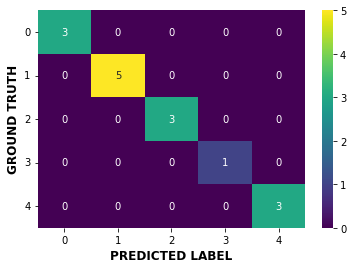

In [9]:
def confusion_matrix_table(y_true, y_pred):
    labels = sklearn.utils.multiclass.unique_labels(y_test)
    columns = [f'{label}' for label in labels]
    index = [f'{label}' for label in labels]
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=labels)
    table = pandas.DataFrame(confusion_matrix, columns=columns, index=index)
    return table

def confusion_matrix_plot(y_true, y_pred):
    table = confusion_matrix_table(y_true, y_pred)
    plot = seaborn.heatmap(table, annot=True, fmt="d", cmap="viridis")
    plt.yticks(rotation=0)
    plt.ylabel(
        'GROUND TRUTH', 
        fontsize = 12, 
        fontweight = 600
    )
    plt.xlabel(
        'PREDICTED LABEL', 
        fontsize = 12, 
        fontweight = 600
    )
    return plot

confusion_matrix_plot(y_test, test_predictions)

In [10]:
# Calculate accuracy on data from duesseldorf
y_duesseldorf = dataframe_duesseldorf['label']
x_duesseldorf = dataframe_duesseldorf.drop(['label', 'path', 'environment'], axis=1)

y_duesseldorf.replace(labels,[0, 1, 2, 3, 4], inplace=True)

cols = x_duesseldorf.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(x_duesseldorf)
x_duesseldorf = pandas.DataFrame(np_scaled, columns = cols)

test_duesseldorf_predictions = model.predict(x_duesseldorf)
print(accuracy_score(y_duesseldorf, test_duesseldorf_predictions))

0.375


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


<AxesSubplot:xlabel='PREDICTED LABEL', ylabel='GROUND TRUTH'>

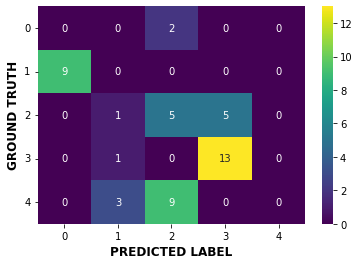

In [11]:
confusion_matrix_plot(y_duesseldorf, test_duesseldorf_predictions)

## Support Vector Classifier trained on data from all environments

In [12]:
# Prepare and split data for training
y = dataframe['label']
x = dataframe.drop(['label', 'path', 'environment'], axis=1)

y.replace(labels,[0, 1, 2, 3, 4], inplace=True)

cols = x.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(x)
x = pandas.DataFrame(np_scaled, columns = cols)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [13]:
model = SVC(
    kernel="rbf",
    gamma="scale",
    probability=True
).fit(x_train, y_train)

In [14]:
test_predictions = model.predict(x_test)
print(accuracy_score(y_test, test_predictions))

1.0


<AxesSubplot:xlabel='PREDICTED LABEL', ylabel='GROUND TRUTH'>

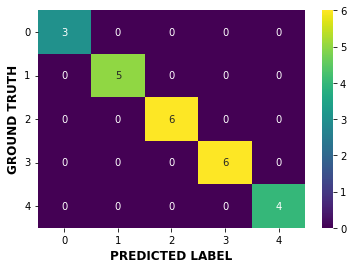

In [15]:
def confusion_matrix_table(y_true, y_pred):
    labels = sklearn.utils.multiclass.unique_labels(y_test)
    columns = [f'{label}' for label in labels]
    index = [f'{label}' for label in labels]
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=labels)
    table = pandas.DataFrame(confusion_matrix, columns=columns, index=index)
    return table

def confusion_matrix_plot(y_true, y_pred):
    table = confusion_matrix_table(y_true, y_pred)
    plot = seaborn.heatmap(table, annot=True, fmt="d", cmap="viridis")
    plt.yticks(rotation=0)
    plt.ylabel(
        'GROUND TRUTH', 
        fontsize = 12, 
        fontweight = 600
    )
    plt.xlabel(
        'PREDICTED LABEL', 
        fontsize = 12, 
        fontweight = 600
    )
    return plot

confusion_matrix_plot(y_test, test_predictions)